# Initialisation and package import

In [1]:
# Data loading and test/train split
from bs4 import BeautifulSoup
from skimage import io
import os
import sys
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt

# VBOW
import cv2 as cv
from scipy.cluster.vq import kmeans, vq
import numpy as np
from skimage.feature import match_descriptors

# HOG
from skimage.feature import hog
from skimage import exposure

# MPEG 
from src.descriptors.descriptor import Descriptor
from src.descriptors.dominant_color import DominantColorDescriptor
from src.descriptors.color_layout import ColorLayoutDescriptor
from src.descriptors.color_structure import ColorStructureDescriptor

# Clustering accuracy
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
import sklearn

# For debugging purposes
import pdb

# Importing the bespoke module for COP-k-Means clustering
sys.path.append("COP-k-Means_dir/COPkMeans/copkmeans")
from cop_kmeans import cop_kmeans 

# Explanations with SHAP
import shap
from sklearn.neural_network import MLPClassifier

# Importing the data 

Link to the Pascal challenge: \
http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html

In order to facilliate the clustering effors and avoid trouble with multi-label images which we are not equipped to solve, we shall only use single-label images, discounting all others. 

##  Load and divide the data into train and test set
- We loop through all annotation xml files
- We load those files in the `getData()` function using BeautifulSoup
- Then we get all the given lables for that image
    - Each XML file contains an object tags for each object in the image within which we can find a name tag wich holds the label
    - We then search for the name tag, strip the opening and closing tag and are left with the label itself
- We do the same to extract the filename of the image and join it with the image path
- We load the image itself using skimage
    - This loads the file as an ndarray consisting of arrays holding the RGB values for each pixel
- In the end we use sklearns `train_test_split()` method to split the data accordingly

In [2]:
# Extra Block for the error AttributeError: 'str' object has no attribute 'removeprefix'.  
def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

def removesuffix(self: str, suffix: str, /) -> str:
    # suffix='' should not call self[:-0].
    if suffix and self.endswith(suffix):
        return self[:-len(suffix)]
    else:
        return self[:]

In [2]:
# Classes: person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, 
# train, bottle, chair, dining table, potted plant, sofa, tv/monitor

jpegPath = './Data_train/JPEGImages'
annotationPath = "./Data_train/Annotations"
images = []
labels = [] # This will be a list (per image) of lists (per label)
x_train = x_test = y_train = y_test = None

def getData(path: str) -> None:
    
    """
    Takes the path to a annotation xml file and appends the lables and the image to the global list.
    
        Parameters:
            path: str

        Returns:
            None
    """
    
    tempLabels = []
    with open(path, 'r') as f:
        data = f.read()

        # The annotations are stored as XML files, use BS to parse them 
        bs_data = BeautifulSoup(data, "xml")

        # GET IMAGE LABELS
        foundLables = bs_data.find_all('object') # This tag holds the labels for the image
        for label in foundLables:
            labelWithTags = str(label.find('name'))
            tempLabels.append(removesuffix(removeprefix(labelWithTags,'<name>'),'</name>'))

        # GET IMAGES
        foundFilenames = bs_data.find('filename') # This holds the filename of the image
        imagePath = os.path.join(jpegPath, removesuffix(removeprefix(str(foundFilenames),'<filename>'),'</filename>'))
        images.append(io.imread(imagePath)) # Load image from specified path (ndarray of color values)
        f.close()
    labels.append(tempLabels)          

def getTestTrainingData():
    
    """
    Goes through the specified annotations directory and splits the found data 50/50 into a training and test set.
    
        Parameters: None

        Returns: None
    """
    
    for annoXML in os.listdir(annotationPath):
        path = os.path.join(annotationPath, annoXML)
        getData(path)
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.5)

getTestTrainingData()
print("Train test split succeded\nTrain size: "+ str(len(x_train))+"\nTest Size: "+str(len(x_test)))

NameError: name 'removesuffix' is not defined

In [2]:
#Classes: person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, tv/monitor

jpegPath = './Data_train/JPEGImages'
annotationPath = "./Data_train/Annotations"
images = []
labels = []
x_train = x_test = y_train = y_test = None

def getData(path: str) -> None:
    """Takes the path to a annotation xml file and appends the lables and the image to the global list.
    
        Parameters:
            path: str

        Returns:
            None
    """
    tempLabels = []
    with open(path, 'r') as f:
        data = f.read()
        bs_data = BeautifulSoup(data, "xml")

        #GET IMAGE LABELS
        foundLables = bs_data.find_all('object') #This holds the labels for the image
        for label in foundLables:
            labelWithTags = str(label.find('name'))
            tempLabels.append(labelWithTags.removeprefix('<name>').removesuffix('</name>'))

        #GET IMAGES
        foundFilenames = bs_data.find('filename') #This holds the filename of the image
        imagePath = os.path.join(jpegPath, str(foundFilenames).removeprefix('<filename>').removesuffix('</filename>'))
        images.append(io.imread(imagePath)) #Load image from specified path (ndarray of color values)
        f.close()
    labels.append(tempLabels)          

def getTestTrainingData():
    """Goes through the specified annotations directory and splits the found data 50/50 into a training and test set.
    
        Parameters: None

        Returns: None
    """
    for annoXML in os.listdir(annotationPath):
        path = os.path.join(annotationPath, annoXML)
        getData(path)
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.5)
    # The x_train/x_test contain the images encoded in RGB whereas the y_train/y_test contain the associated list of labels 

getTestTrainingData()
print("Train test split succeded\nTrain size: "+ str(len(x_train))+"\nTest Size: "+str(len(x_test)))

Train test split succeded
Train size: 2505
Test Size: 2506


In [27]:
print(y_train[:10])
#print(y_test[:10])

[['train'], ['train'], ['aeroplane'], ['dog', 'dog', 'person', 'person'], ['bus', 'bus', 'car'], ['horse', 'horse', 'person', 'person'], ['horse'], ['pottedplant'], ['aeroplane'], ['motorbike', 'motorbike', 'person', 'person', 'motorbike']]


In [3]:
# For removing the repetitive labels in the list and getting the amount of labels for each image 
# in case we need images with more labels later.  

def clean_label(label_list):
    cleaned_label_list = []
    size_array = np.zeros(len(label_list))
    for index in range(len(label_list)):
        if len(label_list[index]) > 1:
            res = [i for n,i in enumerate(label_list[index]) if i not in label_list[index][:n]]
            size_array[index] = len(res)
            cleaned_label_list.append(res)
        else:
            cleaned_label_list.append(label_list[index])
            size_array[index] = 1
    return cleaned_label_list, size_array

y_train_cleaned,train_size_array = clean_label(y_train)
y_test_cleaned,test_size_array = clean_label(y_test)
print(y_train_cleaned[:10])
print(y_test_cleaned[:10])
print(train_size_array[:10])

[['train'], ['car'], ['cat'], ['pottedplant'], ['tvmonitor', 'chair'], ['tvmonitor'], ['car'], ['bicycle', 'person'], ['cat'], ['person', 'horse']]
[['dog'], ['bird'], ['train'], ['person'], ['dog'], ['boat'], ['bird'], ['sofa', 'dog'], ['dog', 'person'], ['tvmonitor', 'pottedplant']]
[1. 1. 1. 1. 2. 1. 1. 2. 1. 2.]


In [4]:
# For choosing the images with only one label

def one_label(size_array):
    #return the index of image with only one label
    label_index = []
    for index, size in enumerate(size_array):
        if size == 1:
            label_index.append(index)
    return label_index
train_label_index = one_label(train_size_array)
test_label_index = one_label(test_size_array)
print(len(train_label_index))
print(len(test_label_index))

x_train_one = [x_train[i] for i in train_label_index]
y_train_one = [y_train_cleaned[i] for i in train_label_index]
x_test_one = [x_test[i] for i in test_label_index]
y_test_one = [y_test_cleaned[i] for i in test_label_index]
print(y_train_one[:5])
print(y_test_one[:5])

1393
1415
[['train'], ['car'], ['cat'], ['pottedplant'], ['tvmonitor']]
[['dog'], ['bird'], ['train'], ['person'], ['dog']]


In [5]:
# for the cluster acc we need int labels instead of string -> label encoding

# create an instance of label encoder
lab = LabelEncoder()

# perform label encoding 
y_train_one_int = lab.fit_transform(y_train_one)

print(y_train_one)
print(y_train_one_int[:10])

[['train'], ['car'], ['cat'], ['pottedplant'], ['tvmonitor'], ['car'], ['cat'], ['bus'], ['pottedplant'], ['aeroplane'], ['bird'], ['sheep'], ['aeroplane'], ['person'], ['boat'], ['cat'], ['car'], ['boat'], ['aeroplane'], ['cow'], ['car'], ['pottedplant'], ['bus'], ['pottedplant'], ['boat'], ['sofa'], ['person'], ['person'], ['tvmonitor'], ['bus'], ['car'], ['tvmonitor'], ['car'], ['cow'], ['motorbike'], ['car'], ['bottle'], ['bottle'], ['person'], ['person'], ['chair'], ['dog'], ['sheep'], ['bottle'], ['horse'], ['cow'], ['bicycle'], ['car'], ['boat'], ['car'], ['bird'], ['person'], ['person'], ['bird'], ['person'], ['bird'], ['person'], ['car'], ['car'], ['bird'], ['motorbike'], ['horse'], ['train'], ['bird'], ['motorbike'], ['cat'], ['person'], ['aeroplane'], ['bottle'], ['boat'], ['car'], ['person'], ['motorbike'], ['bottle'], ['car'], ['person'], ['aeroplane'], ['horse'], ['person'], ['person'], ['cow'], ['car'], ['person'], ['car'], ['dog'], ['sheep'], ['chair'], ['bird'], ['trai

c:\Users\evist\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


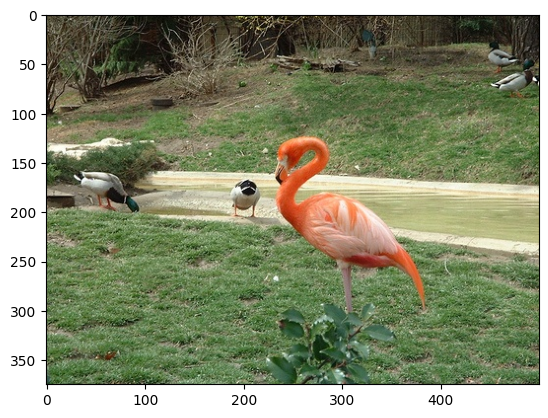

In [7]:
plt.imshow(x_train[0])

In [10]:
tfidf = bovw(x_train[:50], 50, 250)


keypoints and descriptors extracted
(< cv2.KeyPoint 0000028A1FA28480>, < cv2.KeyPoint 0000028A1FA28930>, < cv2.KeyPoint 0000028A1FA28BA0>, < cv2.KeyPoint 0000028A1FA283F0>, < cv2.KeyPoint 0000028A1FA28750>, < cv2.KeyPoint 0000028A1FA28720>, < cv2.KeyPoint 0000028A1FA28CC0>, < cv2.KeyPoint 0000028A1FA28D50>, < cv2.KeyPoint 0000028A1FA28D80>, < cv2.KeyPoint 0000028A1FA28AE0>, < cv2.KeyPoint 0000028A1FA28840>, < cv2.KeyPoint 0000028A1FA28330>, < cv2.KeyPoint 0000028A1FA28660>, < cv2.KeyPoint 0000028A1FA283C0>, < cv2.KeyPoint 0000028A1FA28F90>, < cv2.KeyPoint 0000028A1FA28ED0>, < cv2.KeyPoint 0000028A1FA28F00>, < cv2.KeyPoint 0000028A1FA28690>, < cv2.KeyPoint 0000028A5F830A20>, < cv2.KeyPoint 0000028A5FB55B70>, < cv2.KeyPoint 0000028A5FA62B40>, < cv2.KeyPoint 0000028A5FA628A0>, < cv2.KeyPoint 0000028A5FA62330>, < cv2.KeyPoint 0000028A5FA62C00>, < cv2.KeyPoint 0000028A5FA62A50>, < cv2.KeyPoint 0000028A5F8331B0>, < cv2.KeyPoint 0000028A5F833030>, < cv2.KeyPoint 0000028A7FF14420>, < cv2.KeyPo

In [15]:
print(len(tfidf))
print(len(tfidf[0]))

50
50


In [43]:
tfidf

array([[20., 19., 18., ..., 24., 23., 27.],
       [ 7.,  7.,  2., ...,  2.,  4.,  9.],
       [12., 22.,  5., ..., 18., 16., 36.],
       ...,
       [18., 23., 13., ..., 17., 25., 23.],
       [21., 21., 12., ..., 11., 24., 19.],
       [17., 13.,  5., ..., 13.,  6.,  8.]])

In [13]:
hogfd = HOG_extractor(x_train[:500])
hogfd

array([[0.6135993 , 0.17420042, 0.13812273, ..., 0.23033451, 0.34033488,
        0.13920484],
       [0.6272774 , 0.23477052, 0.32669817, ..., 0.23027076, 0.44495737,
        0.26417126],
       [0.79973473, 0.13762262, 0.21711812, ..., 0.33508714, 0.41571747,
        0.27764662],
       ...,
       [0.66881225, 0.22846632, 0.35195778, ..., 0.44722539, 0.46133285,
        0.14119727],
       [0.47292794, 0.16192481, 0.19144276, ..., 0.4507705 , 0.22021719,
        0.25232076],
       [0.47535646, 0.26153079, 0.51199914, ..., 0.31009018, 0.39616514,
        0.41840699]])

In [27]:
# MPEG ColorLayoutDescriptor
train_image_list = x_train[:500]  
descriptor_used = ColorLayoutDescriptor(y_coeff_number, c_coeff_number, w_y, w_cr, w_cb)  #change here if changing descriptors of MPEG 
CLD_descriptor  = train(train_image_list, descriptor_used)
CLD_descriptor_array = np.array(CLD_descriptor)
CLD_descriptor_array[:10]
#print(CLD_descriptor_array[0][1])

training 500 images


array([[1117,  -86, -216,   64,  -42,  -86, 1133,   -5,  -12,  899,    4,
          15],
       [ 767, -142,  221,  332,   73,  -67,  967,    5,    3, 1098,   -1,
          -1],
       [1080,   -8,  -65,   98,   80,  -37,  938,   -2,   44, 1186,    1,
         -25],
       [ 983, -102, -153, -111,  -11,  155, 1016,    9,  -39, 1041,    7,
          39],
       [ 777,  135,  292,  -33,   91, -187, 1007,   -9,    9, 1030,    6,
          -6],
       [ 884,  115, -199,   58,  -27,   81,  940,  -21,  -30, 1122,   19,
          36],
       [ 867,  -96,   94, -219,   43,  319,  943,   11,  -16, 1061,   -5,
           7],
       [ 890,   84,  114,   71,  122,  -34, 1007,    8,  -15, 1040,   -7,
          14],
       [1022,   75,   20, -129,  -43,    0, 1205,   22,  113,  843,  -26,
         -96],
       [1204,  -61,  -14,  321,  -31,  -72,  993,   -9,   -5, 1053,   10,
           6]])

In [28]:
print(CLD_descriptor_array.shape)

(500, 12)


In [29]:
# MPEG ColorStructureDescriptor, more sparse
train_image_list = x_train[:500]  
descriptor_used = ColorStructureDescriptor(n_quantization)
CSD_descriptor = train(train_image_list, descriptor_used)
CSD_descriptor_array = np.array(CSD_descriptor)
# Make sure we have enough pictures for each distinct label 
unique_labels, counts = np.unique(y_train_one, return_counts=True)

# Sorting the counts and labels in ascending order
sorted_indices = np.argsort(counts)[::-1]
unique_labels = unique_labels[sorted_indices]
counts = counts[sorted_indices]

# Plotting the bar chart
plt.bar(unique_labels, counts)

# Increasing the spacing between the ticks
plt.xticks(ticks=np.arange(len(unique_labels)), labels=unique_labels, rotation=45, ha='right')

# Prevent clipping of tick labels
plt.tight_layout()

plt.show()

training 500 images
[[ 30  28  36  42   0   0   0   0 110 130   0   0  26  29   0   0  45  52
    0   0   0   0   0   0  40 213   0   0  21  17   0   0   2   3   0   0
    0   0   0   0  56   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [173  77  71 120   0   0   0   0  38  22   0   0 231  85   0   0  12  20
    0   0   0   0   0   0   0   1   0   0 242 178   0   0   2   6   0   0
    0   0   0   0   0   0   0   0  13   0 207   0   0   0   0   0   0   0
    0   0   0   0   0  38   0   0   0   0]]
(500, 64)


# Feature selection / vectorising the data

Feature extraction methods used in this project: 

1. Histogram of Oriented Gradients (HOG)  \
 https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
2. Visual Bag-of-Words (VBOW) \
https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision
3. MPEG-7 Color Layout Descriptor \
 https://en.wikipedia.org/wiki/Color_layout_descriptor


This is very important, one of the tasks being "Extract meaningful hand-crafted features \[...] using appropriate libraries or implement them from scratch. Reference to some hand-crafted features are provided. Identify and extract at least one extra feature of your choice other than the three features mentioned in the task. Why did you select this these feature(s) out of other options?
"

## Feature extraction - function definition

### HOG

Histogram of Oriented Gradients, aka HOG, is the one extra feature extraction method not mentioned in the task assignment. 

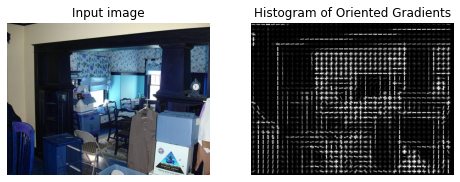

In [7]:
# The following dummy code is for visualisation purposes only for an easy understanding of what HOG performs 

# Load a sample image
image = cv.imread("./Data_train/JPEGImages/000005.jpg")

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(12, 12),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [8]:
def HOG_extractor(data: list, block_norm: str = 'L2') -> np.ndarray:

    """
    A wrapper for extracting features using the Histogram of Oriented Gradients method.
    All images are resised to the same dimensions and blurred with a Gaussian filter. 
    Optionally specify different normalisation, the default is L2. 
    """

    # Initialise an empty list of features
    hog_features = []

    # Iterate over the images 
    for img in data:

        # Resize the images
        image = cv.resize(img, (150, 200), interpolation = cv.INTER_LINEAR)

        # Apply Gaussian filter
        blur = cv.GaussianBlur(image, (5, 5), 0)

        # Extract the features using HOG
        fd = hog(
        image,
        orientations=8,
        pixels_per_cell=(12, 12),
        cells_per_block=(1, 1),
        channel_axis=-1, # Specify the colour channel as the last column
        block_norm = block_norm) 

        hog_features.append(fd)
        
    return np.array(hog_features)

### Visual Bag of Words

https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/

BoVW is a method used for building image emeddings.

1. Extract visual features -> SIFT
    - consist of keypoints: points that do not change if image is rotated, expanded or scaled
    - And descriptors: vector representations of an image patch found at a given keypoint
2. Create codebook with all existing visual words -> k-means
3. Build sparse frequency vectors with these visual words

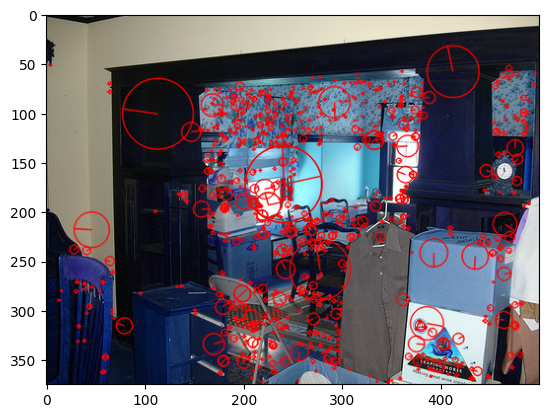

In [7]:
# just to visualize what keypoints / descriptors are about on an example image

# Load a sample image
img = cv.imread("./Data_train/JPEGImages/000005.jpg")

# extract keypoints & descriptors from image via sift
extractor = cv.SIFT_create()
img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)

output_image = []
output_image.append(cv.drawKeypoints(img, img_keypoints, 0, (255, 0, 0),
                                 flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.imshow(output_image[0], cmap='gray')
plt.show()

In [40]:
codebook, tfidf = bovw(x_train[:50], 50, 250)

keypoints and descriptors extracted
All feature vectors gathered. Now: building codebook
codebook finished
vectors quantization done, now: creating sparse frequency vectors
finished bovw


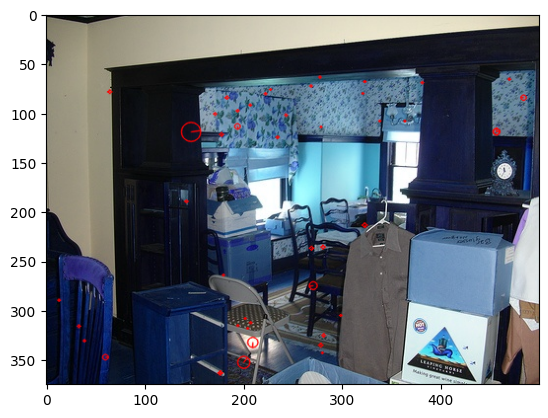

In [41]:
# visualize the features that are matching with the codebook for example image
matches = match_descriptors(img_descriptors, codebook)
output_image = []
output_image.append(cv.drawKeypoints(img, np.array(img_keypoints)[matches[:,0]], 0, (255, 0, 0),
                                 flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.imshow(output_image[0], cmap='gray')
plt.show()

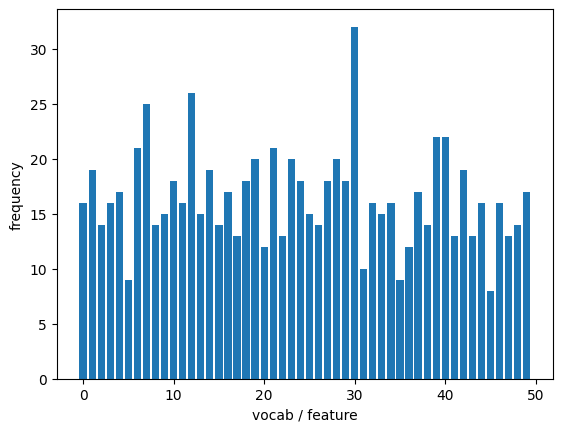

In [15]:
# visualization of frequencies of vocabs in the codebook for a single image
sample_ind = 10

plt.bar(range(50), tfidf[sample_ind])
plt.xlabel("vocab / feature")
plt.ylabel("frequency")
plt.show()

In [39]:
# hyperparam iterations = 1?
# param data: list of images on which to apply bovw
# param n_words: how large should the codebook be?
# param n_samples: how many samples to build the codebook?
def bovw(data, n_words, n_samples, iterations=1):
    # extractor SIFT to get the visual features
    extractor = cv.SIFT_create()

    # lists to store all keypoints and descriptors
    keypoints = []
    descriptors = []

    for img in data:
        img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
        keypoints.append(img_keypoints)
        descriptors.append(img_descriptors)

    print("keypoints and descriptors extracted")

    # get sample of descriptors
    # select n_samples random image index values
    sample_idx = np.random.randint(0, len(data), n_samples).tolist()

    # extract the sample from descriptors
    # (we don't need keypoints)
    descriptors_sample = []

    for n in sample_idx:
        descriptors_sample.append(np.array(descriptors[n]))

    all_descriptors = []
    # convert all discriptors into a single array (some images may have more than others)
    for img_descriptors in descriptors_sample:
        # extract specific descriptors within the image
        for descriptor in img_descriptors:
            all_descriptors.append(descriptor)
    
    # convert to single numpy array (contains all feature vectors)
    all_descriptors = np.stack(all_descriptors)

    print("All feature vectors gathered. Now: building codebook")

    # perform k-means clustering to build the codebook
    k = n_words
    codebook, variance = kmeans(all_descriptors, k_or_guess=n_words, iter=iterations)

    #print(codebook)
    print("codebook finished")

    # vector quantization
    visual_words = []
    for img_descriptors in descriptors:
        # for each image map each descriptor to the nearest codebook entry
        img_visual_words, distance = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)

    print("vectors quantization done, now: creating sparse frequency vectors")
    # creating sparse frequency_vectors 
    frequency_vectors = []
    for img_visual_words in visual_words:
        # create frequency vector for each image
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)       
    # stack together in numpy array
    frequency_vectors = np.stack(frequency_vectors)

    print("finished bovw")


    return codebook,frequency_vectors



### MPEG-7

MPEG-7 is a multimedia content description standard.The following descriptor methods can be used. 
- Color Layout Descriptor (CLD): Captures the spatial distribution of colors in an image. It divides the image into a grid and computes color moments for each grid cell.The feature extraction process consists of two parts: grid based representative color selection and discrete cosine transform with quantization.[It is a reference feature in the task document.]

- Dominant Color Descriptor (DCD): Captures the dominant colors in an image. It quantizes the color space and computes the frequency of each color cluster.

- Color Structure Descriptor (CSD): Describes the spatial arrangement of color structures in an image. It analyzes the distribution of color pairs in predefined directions.

In [10]:
"""
The toolkit originally comes from https://github.com/lucas-gtr/MPEG7_Descriptors with 
adaption for the project. It includes three functions: training, evaluation and querying
the descriptors. 
"""

#def train(train_image_list: list, descriptor_used: Descriptor, output_file: str):
def train(train_image_list: list, descriptor_used: Descriptor):
    """
    Uses selected descriptor on a set of images and saves the results to a file.

    Args:
        train_image_list(list): A list containing training images.
        descriptor_used (str): Descriptor to use.
        output_file (str): Path to the output file.
    """
    n_images = len(train_image_list)
    #print(f"training {n_images} images")
    descriptor_list = []
    
    for idx, img in enumerate(train_image_list):
        descriptor = descriptor_used.get_descriptor(img)
        descriptor_list.append(descriptor)
    return descriptor_list

In [11]:
"""
1. Three modes to be chosen:
Train: train(train_image_list: list, descriptor_used: Descriptor, output_file: str)
Evaluate: evaluate(test_image_list: list,y_true: list, descriptor_used: Descriptor, descriptor_database: str)
Query: query(query_img_list: list, descriptor_used: Descriptor, descriptor_database: str)

2. x_image_list is the list containing image, 
   output_file and descriptor_database are paths, 
   descriptor_used can be chosen from: 
     1) DCD: DominantColorDescriptor(Td, alpha),
     2) CLD: ColorLayoutDescriptor(y_coeff_number, c_coeff_number, w_y, w_cr, w_cb),
     3) CSD: ColorStructureDescriptor(n_quantization) 
    Variables are temporaily fixed belows. 
"""

# Variables for Dominant Color Descriptor
Td = 20  # For distance calculation (usually between 10 and 20)
alpha = 1.5  # For distance calculation (usually between 1.0 and 1.5)

# Variables for Color Layout Descriptor
y_coeff_number = 6  # For descriptor size
c_coeff_number = 3  # For descriptor size (usually there are more Y coeff number than Cr, Cb)
# Weights for distance calculation
w_y = 1
w_cr = 1
w_cb = 1

# Variables for Color Structure Descriptor
n_quantization = 64  # For descriptor size
assert n_quantization in {32, 64, 128, 256}, "The value of n_quantization must be 32, 64, 128, or 256."

## Feature extraction - execution

### MPEG 

In [42]:
# CLD Color Layout Descriptor
descriptor_used = ColorLayoutDescriptor(y_coeff_number, c_coeff_number, w_y, w_cr, w_cb)  # Change here if changing descriptors of MPEG 
CLD_descriptor = train(x_train_one, descriptor_used)
CLD_descriptor_array = np.array([list(map(int, s.split())) for s in CLD_descriptor])
print(CLD_descriptor_array[:10])
print(CLD_descriptor_array.shape)

[[ 821   10  -57    4  -17  -40  942   -3    9 1099    5   -7]
 [1198    8 -298  123   15   57 1056  -64    5  994   56   -7]
 [1101   87  343 -188  -22   16  986   12   36  997   -4  -44]
 [1152 -157  572 -114  -80   80 1000    1   11 1030   -1    4]
 [ 394  133   16  -83   44  -13 1000   27   -1 1071  -18   -6]
 [ 822  205   -8  -54   62 -138  967    8    3 1120   -1   -4]
 [1128  149  564  104   -9   43 1026    1  -14 1021   -1    5]
 [ 543  -73  -16  -99   52  -68  971   11    6 1107   -7  -10]
 [ 239    9   95  -16   24  -80 1015  -18   -3 1044   14    0]
 [ 898  -64  289   61   -4    4 1002    2    2 1019    7  -18]]
(1404, 12)


In [25]:
# CSD Color Structure Descriptor, more sparse
descriptor_used = ColorStructureDescriptor(n_quantization)
CSD_descriptor = train(x_train_one, descriptor_used)
CSD_descriptor_array = np.array([list(map(int, s.split())) for s in CSD_descriptor])
print(CSD_descriptor_array[:2])
print(CSD_descriptor_array.shape)

[[ 76  51  50  40   0   0   0   0   5   3   0   0 160 175   0   0   7   4
    0   0   0   0   0   0   0   0   0   0  94 113   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  28   0 151   0   0   0   0   0   0   0
    0   0   0   0   0   7   0   0   0   0]
 [140 168   2 121   0   0   0   0 202 218   0   0 216 176   0   0 118 151
    0   0   0   0   0   0 153 127   0   0 229 134   0   0  46  39   0   0
    0   0   0   0 138   0   1   0   6   0  23   0   8   0   0   0   0   0
    0   0 111   0   4   1   0   0   0   0]]
(1404, 64)


In [23]:
# for the cluster acc we need int labels instead of string -> label encoding

# create an instance of label encoder
lab = LabelEncoder()

# perform label encoding
y_train_one_int = lab.fit_transform(y_train_one)

D:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### VBOW

In [11]:
codebook,tfidf = bovw(x_train_one, 50, 250)

keypoints and descriptors extracted
(< cv2.KeyPoint 0000028A5FA430C0>, < cv2.KeyPoint 0000028A5FAD45D0>, < cv2.KeyPoint 0000028A66DCCC30>, < cv2.KeyPoint 0000028A1FA28FC0>, < cv2.KeyPoint 0000028A1FA28F60>, < cv2.KeyPoint 0000028A1FA28B70>, < cv2.KeyPoint 0000028A1FA28600>, < cv2.KeyPoint 0000028A1FA28C90>, < cv2.KeyPoint 0000028A1FA28D20>, < cv2.KeyPoint 0000028A1FA283C0>, < cv2.KeyPoint 0000028A1FA28090>, < cv2.KeyPoint 0000028A1FA28BD0>, < cv2.KeyPoint 0000028A1FA28420>, < cv2.KeyPoint 0000028A1FA28CF0>, < cv2.KeyPoint 0000028A1FA28750>, < cv2.KeyPoint 0000028A1FA28B40>, < cv2.KeyPoint 0000028A1FA28DE0>, < cv2.KeyPoint 0000028A1FA28390>, < cv2.KeyPoint 0000028A1FA28F90>, < cv2.KeyPoint 0000028A1FA28ED0>, < cv2.KeyPoint 0000028A1FA28D80>, < cv2.KeyPoint 0000028A5FA628A0>, < cv2.KeyPoint 0000028A5FA62B40>, < cv2.KeyPoint 0000028A5FA62330>, < cv2.KeyPoint 0000028A5FA62C00>, < cv2.KeyPoint 0000028A5FA62A50>, < cv2.KeyPoint 0000028A5F8331B0>, < cv2.KeyPoint 0000028A5F833030>, < cv2.KeyPo

In [41]:
print(tfidf[:5])
print(tfidf.shape)

[[23. 65. 40. 54. 14. 27. 47. 54. 20. 15. 35. 20. 33. 65. 47. 29. 26. 43.
  45. 63. 26. 20. 46. 15. 38. 34. 25. 38. 36. 93. 21. 35. 15. 65. 15. 21.
  72. 21. 60. 29. 13. 59. 18. 22. 19. 20. 16. 22. 26. 45.]
 [ 6.  3. 14. 26.  5. 15.  6. 35.  5.  4.  4. 18.  5.  9. 16. 13. 14. 15.
   7. 13.  9.  5.  6.  5.  9.  5.  6. 15. 23. 41.  0.  4. 17. 10.  8. 10.
   8.  1.  2.  8.  4. 26.  5.  3.  6.  2. 10. 17.  4. 10.]
 [13.  0. 11.  0. 16.  2.  1.  2.  4.  3. 10.  7.  5.  8.  6.  3. 11.  8.
   6.  3.  8. 13.  6. 13. 10. 18. 19.  1.  4.  0.  2.  3. 10.  2. 11. 10.
   6.  0.  6. 15. 16.  5.  7. 10.  1.  6.  8. 18.  5. 13.]
 [21.  4. 21. 25.  4. 17. 20. 22. 11.  5. 26.  9. 11. 42. 19. 30.  8. 17.
  14. 27. 20.  2. 31. 11. 10. 10. 17.  8. 22. 20.  3. 29. 14. 40. 15.  7.
  44. 25. 35.  9.  7. 60. 17. 13. 16. 22.  2. 20.  7. 12.]
 [24. 14. 30.  8. 38. 20.  5. 11. 29. 31.  9.  7. 26. 13. 12. 14. 16. 30.
  17. 23. 18. 18. 11. 25.  5. 15. 14. 24. 22.  7.  1. 34. 22. 22. 26. 29.
  20. 11.  9. 25. 22. 19

### HOG

In [37]:
hogfd = HOG_extractor(x_train_one)

In [40]:
print(hogfd[:5])
print(hogfd.shape)

[[0.27518045 0.28162835 0.25145319 ... 0.65147469 0.70791316 0.10122539]
 [0.70468736 0.16694749 0.20700714 ... 0.1922913  0.09619952 0.09542014]
 [0.49749537 0.28486958 0.15254076 ... 0.18906528 0.15743336 0.19419163]
 [0.62959174 0.25099719 0.25069053 ... 0.31233397 0.48274863 0.31224183]
 [0.32612754 0.90876942 0.2431239  ... 0.62373864 0.11884361 0.12845786]]
(1404, 1536)


# Clutering and gridsearch cross-validation

We are using the COP-k-Means for clustering with a fixed k of 20 and two types of constraints, must-link and cannot link. We will firstly perform the clustering with no constraints and then introduce simulated domain knowledge. The performance of the clustering will be evaluated with accuracy (an extrinsic method) since we have the ground truth. 

The paper that describes the algorithm is here:\
https://web.cse.msu.edu/~cse802/notes/ConstrainedKmeans.pdf 

In [66]:
# A try run of cop_kmeans
input_matrix = np.random.rand(100, 1)
must_link = [(0, 10), (0, 20), (0, 30)]
cannot_link = [(1, 10), (2, 10), (3, 10)]
clusters, centres = cop_kmeans(dataset=input_matrix, k=5, ml=must_link,cl=cannot_link)
clusters[:10]

[1, 2, 0, 2, 1, 1, 2, 3, 1, 4]

In [28]:
clusters_VBOW, centres_VBOW = cop_kmeans(tfidf, k=20)

In [29]:
# Obtain the clustering accuracy using 
sklearn.metrics.rand_score(y_train_one_int, np.array(clusters_VBOW))

0.8008084020200913

In [24]:
clusters_CLD, centres_CLD = cop_kmeans(CLD_descriptor_array, k=20)
sklearn.metrics.rand_score(y_train_one_int, np.array(clusters_CLD))

0.8755058858408823

In [26]:
clusters_CSD, centres_CSD = cop_kmeans(CSD_descriptor_array, k=20)
sklearn.metrics.rand_score(y_train_one_int, np.array(clusters_CSD))

0.8780909041065847

# Evaluation of the quality of clusters

## A. Instrinsic measures-when the ground truth is not available
- 1. Davies-Bouldin Index. It assesses the average similarity ratio of each cluster with its most similar cluster and evaluates the compactness and separation of clusters. The lower the better.  
- 2. Silhouette Coefficient. It estimates the average distance between clusters and measures how similar an object is to its own cluster compared to other clusters. The higher the better. 
- 3. Calinski-Harabasz Index. It evaluates cluster validity based on the ratio of the sum of between-cluster dispersion and within-cluster dispersion. The higher the better. 

In [44]:
# 1. Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
db_CLD = davies_bouldin_score(CLD_descriptor_array,clusters_CLD) 
print("Davies-Bouldin Index of CLD is:", db_CLD)

db_CSD = davies_bouldin_score(CSD_descriptor_array,clusters_CSD) 
print("Davies-Bouldin Index of CSD is:", db_CSD)

db_VBOW = davies_bouldin_score(tfidf,clusters_VBOW)
print("Davies-Bouldin Index of bovw is:", db_VBOW)

# db_hog = davies_bouldin_score(hogfd,clusters_hog) 
# print("Davies-Bouldin Index of hog is:", db_hog)

# 2. Silhouette Coefficient
from sklearn.metrics import silhouette_score
sil_CLD = silhouette_score(CLD_descriptor_array,clusters_CLD) 
print("Silhouette Coefficient of CLD is:", sil_CLD)

sil_CSD = silhouette_score(CSD_descriptor_array,clusters_CSD) 
print("Silhouette Coefficient of CSD is:", sil_CSD)

sil_VBOW = silhouette_score(tfidf,clusters_VBOW)
print("Silhouette Coefficient of bovw is:", sil_VBOW)

# sil_hog = silhouette_score(hogfd,clusters_hog)
# print("Silhouette Coefficient of hog is:", sil_hog)

#  3. Calinski-Harabasz Index
from sklearn.metrics import calinski_harabasz_score
ch_CLD = calinski_harabasz_score(CLD_descriptor_array,clusters_CLD) 
print("Calinski-Harabasz Index of CLD is:", ch_CLD)

ch_CSD = calinski_harabasz_score(CSD_descriptor_array,clusters_CSD) 
print("Calinski-Harabasz Index of CSD is:", ch_CSD)

ch_VBOW = calinski_harabasz_score(tfidf,clusters_VBOW)
print("Calinski-Harabasz Index of bovw is:", ch_VBOW)

# ch_hog = calinski_harabasz_score(hogfd,clusters_hog)
# print("Calinski-Harabasz Index of hog is:", ch_hog)

Davies-Bouldin Index of CLD is: 1.7175528909203148
Davies-Bouldin Index of CSD is: 2.4218830282873776
Davies-Bouldin Index of bovw is: 1.7269728022011734
Silhouette Coefficient of CLD is: 0.12082150247360124
Silhouette Coefficient of CSD is: 0.07015500211250267
Silhouette Coefficient of bovw is: 0.0959650886116778
Calinski-Harabasz Index of CLD is: 152.9593511171602
Calinski-Harabasz Index of CSD is: 53.744948977542386
Calinski-Harabasz Index of bovw is: 150.9499218932412


accuracy measures

In [31]:
# taken from https://github.com/k-han/DTC/blob/master/utils/util.py and modified, because it only worked for two classes
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    cost_matrix = w.max()-w
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    #print(f"row_ind: {row_ind}")
    #print(f"col_ind: {col_ind}")
    #print(cost_matrix)
    sum = 0 
    for i in range(row_ind.size):
        sum += w[row_ind[i], col_ind[i]]


    return sum / y_pred.size
    


In [35]:
# get the cluster acc for our example clustering example with tfidf
cluster_acc(y_train_one_int, np.array(clusters_VBOW))

0.18803418803418803

In [36]:
cluster_acc(y_train_one_int, np.array(clusters_CLD))

0.1452991452991453

In [45]:
cluster_acc(y_train_one_int, np.array(clusters_CSD))

0.14458689458689458

In [112]:
sklearn.metrics.rand_score(y_train_one_int, np.array(clusters_VBOW))

0.8087434128265745

# Generating Explanations

In [7]:
# get the features we want to use for the explanation
codebook,tfidf = bovw(x_train, 50, 250)
features = tfidf

# run cop k means to get the cluster assignments
clusters_bovw, centres_bovw = cop_kmeans(dataset=tfidf, k=20)

# get classifier on which to generate the explanations
classifier = MLPClassifier(hidden_layer_sizes=(100,64))

# train classifier: input: features, output: predicted cluster assignment by cop k means
classifier.fit(tfidf, clusters_bovw)
print(classifier.score(tfidf, clusters_bovw))


keypoints and descriptors extracted
(< cv2.KeyPoint 000001DF63F58810>, < cv2.KeyPoint 000001DF63F58210>, < cv2.KeyPoint 000001DF63F58A80>, < cv2.KeyPoint 000001DF63F585D0>, < cv2.KeyPoint 000001DF63F58480>, < cv2.KeyPoint 000001DF63F58DE0>, < cv2.KeyPoint 000001DF63F58270>, < cv2.KeyPoint 000001DF63F580F0>, < cv2.KeyPoint 000001DF63F58780>, < cv2.KeyPoint 000001DF63F58450>, < cv2.KeyPoint 000001DF63F58FC0>, < cv2.KeyPoint 000001DF63F58E70>, < cv2.KeyPoint 000001DF63F588D0>, < cv2.KeyPoint 000001DF63F58510>, < cv2.KeyPoint 000001DF63F582D0>, < cv2.KeyPoint 000001DF63F58B40>, < cv2.KeyPoint 000001DF63F58A20>, < cv2.KeyPoint 000001DF63F58990>, < cv2.KeyPoint 000001DF63F58DB0>, < cv2.KeyPoint 000001DF63F58C90>, < cv2.KeyPoint 000001DF63F58540>, < cv2.KeyPoint 000001DF63F58CF0>, < cv2.KeyPoint 000001DF63F58930>, < cv2.KeyPoint 000001DF63F58D20>, < cv2.KeyPoint 000001DF63F58B70>, < cv2.KeyPoint 000001DF63F584E0>, < cv2.KeyPoint 000001DF63F581B0>, < cv2.KeyPoint 000001DF63F58390>, < cv2.KeyPo

In [119]:
# https://towardsdatascience.com/how-to-make-clustering-explainable-1582390476cc
def f(x):
    return classifier.predict_proba(x)[:, 0]


shap.initjs()

explainer = shap.Explainer(f, features)
shap_values = explainer(features)

# for single prediction
sample_ind = 0
explainer2 = shap.KernelExplainer(classifier.predict_proba, features)
shap_values2 = explainer2.shap_values(features[sample_ind,:])


In [246]:
instance_ind = 10
cluster_nr = classifier.predict(features[instance_ind].reshape(1, -1))
print(f"classifier predicts assignment to cluster: {cluster_nr[0]}")

shap.force_plot(explainer2.expected_value[0], shap_values2[:,cluster_nr[0]], features[instance_ind])

classifer predicts assignment to cluster: 1


Here we can see, that the classifier assigns the instance with a confidence of 0.80 to cluster 1. features 6,9,5,4,2,1 were the features that contributed the most to the prediction of cluster 1.

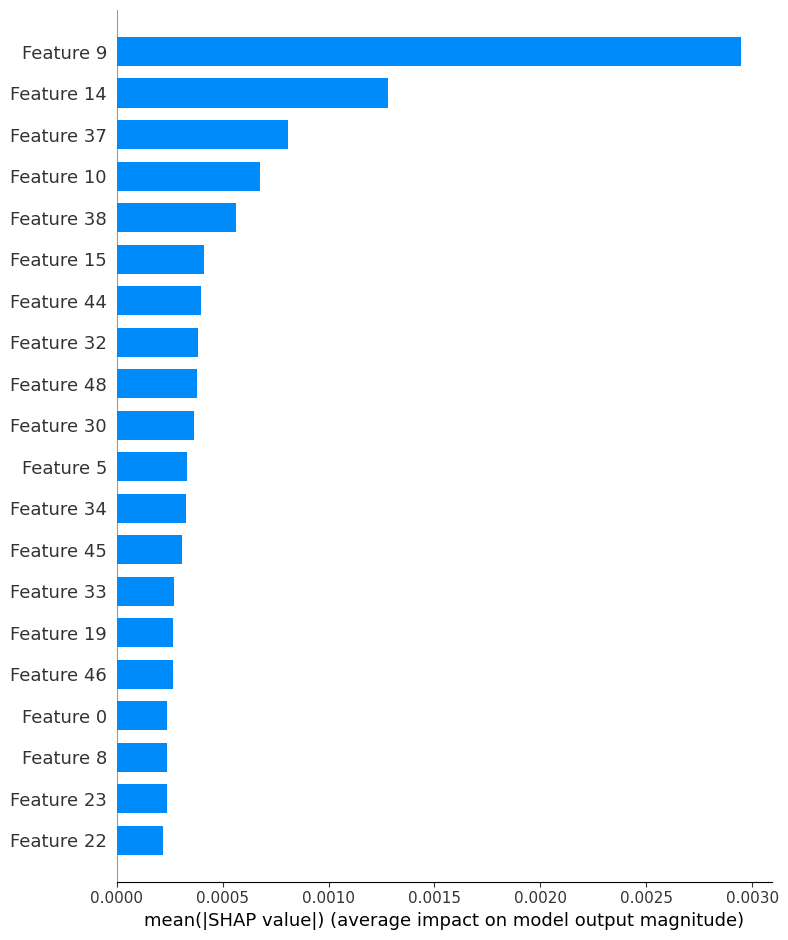

In [186]:
shap.summary_plot(shap_values, features, plot_type="bar")

Here we can see the average impact a feature has on the predictions of the model

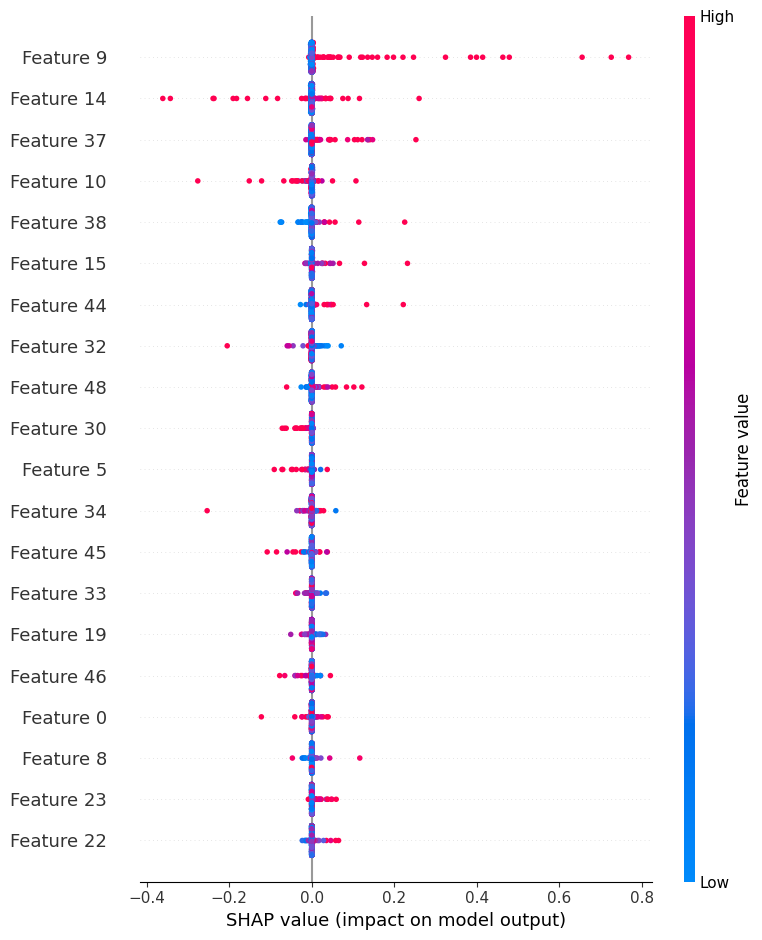

In [214]:
# create a beeswarm plot
shap.summary_plot(shap_values, features)